### 1. Importing necessary packages

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
# initializing the initial learning rate, number of epochs and batch size
EPOCHS = 20
LEARNING_RATE = 1e-4
BATCH_SZ = 32

In [6]:
# defining the data path and defining the categories
BASEDIR = "./dataset"
CATEGORIES = ["with_mask", "without_mask"]

### 2. Data preprocessing

In [14]:
#loading the labled dataset
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(BASEDIR, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224)) # loading an image in an converting to uniform size
        image = img_to_array(image) # converts image to array (2D)
        image = preprocess_input(image) #is used because mobilenet_v2 is used
        
        data.append(image)
        labels.append(category)

c:\users\robin\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [15]:
# preform one-hot-encoding on all the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels) #transfroms categories into integers (0 or 1 since it's binary)
labels = to_categorical(labels) #transforms class vector into sparse matrix (one-hot)

In [16]:
# converting lists into numpy arrays since most ml models will only work with numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [17]:
# splitting the data into train and test data
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=.2, stratify=labels, random_state=42)

### 3. Constructing the model and it's submodels

<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png" width="600">

In [19]:
# training two models. First training the mobilenet model and it's output will then be used to train the "normal" model
# mobilenet = base model
# other model = head model
# --> Model stacking

# first construct the training image generator for data augmentation (adds slightly modified copies of existing data)
# --> regularizer to prevent overfitting

augmentation_model = ImageDataGenerator(rotation_range=20,
                                        zoom_range=0.15,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.15,
                                        horizontal_flip=True,
                                        fill_mode='nearest'
)

base_model = MobileNetV2(weights="imagenet", #weigts = "imagenet" uses pre-trained image focudes models to make a better weight inititalization
                         include_top=False, #include_top=False doesn't include fully connceted top layer since not needed
                         input_tensor=Input(shape=(224, 224, 3))) # 224px X 224px with 3 color channels (RGB)

# constructiong the head model that will be added on top of the base model
head_model = base_model.output #output layer of base_model will be input layer for head_model
head_model = AveragePooling2D(pool_size=(7,7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model) #relu is well suited for non linear use cases
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model) # all activations between 0 & 1 and their sum will be 1

# constructing the final model
model = Model(inputs=base_model.input, outputs=head_model)

# looping over all layers in the base model and prevents the trainability an will not be updated during the first training process
# Necessary because they're a replacement for CNN
for layer in base_model.layers:
    layer.trainable=False

9412608/9406464 [==============================] - 5s 1us/step


### 4. Defining an Adam optimizer and compiling the model

In [20]:
optimizer = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / EPOCHS) # Adam is a go to optimizer for image recognition
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### 5. Training the model

In [21]:
history = model.fit(
    augmentation_model.flow(X_train, y_train, batch_size=BATCH_SZ), #augmenting training data to get more and reduce variance
    steps_per_epoch=len(X_train) // BATCH_SZ,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BATCH_SZ,
    epochs=EPOCHS
)

Epoch 1/20
95/95 [==============================] - 52s 548ms/step - loss: 0.3674 - accuracy: 0.8355 - val_loss: 0.0963 - val_accuracy: 0.9765
Epoch 2/20
95/95 [==============================] - 51s 540ms/step - loss: 0.1264 - accuracy: 0.9581 - val_loss: 0.0550 - val_accuracy: 0.9896
Epoch 3/20
95/95 [==============================] - 51s 538ms/step - loss: 0.0877 - accuracy: 0.9684 - val_loss: 0.0420 - val_accuracy: 0.9922
Epoch 4/20
95/95 [==============================] - 51s 541ms/step - loss: 0.0709 - accuracy: 0.9759 - val_loss: 0.0342 - val_accuracy: 0.9948
Epoch 5/20
95/95 [==============================] - 51s 542ms/step - loss: 0.0705 - accuracy: 0.9782 - val_loss: 0.0322 - val_accuracy: 0.9948
Epoch 6/20
95/95 [==============================] - 51s 539ms/step - loss: 0.0489 - accuracy: 0.9838 - val_loss: 0.0299 - val_accuracy: 0.9948
Epoch 7/20
95/95 [==============================] - 51s 539ms/step - loss: 0.0418 - accuracy: 0.9845 - val_loss: 0.0286 - val_accuracy: 0.9948

In [22]:
# making predictions on the test data
preds = model.predict(X_test, batch_size=BATCH_SZ)

# finding the index of the label with the highest probability for each label
preds = np.argmax(preds, axis=1)

### 6. Classification report

In [23]:
print(classification_report(y_test.argmax(axis=1), preds, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



### 7. Saving the model locally

In [24]:
model.save("face_mask_detector.model", save_format="h5")

### 8. Plotting the training process

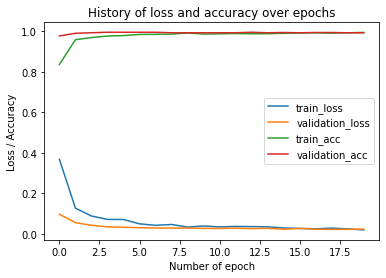

In [27]:
N = EPOCHS

plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="validation_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="validation_acc")

plt.title("History of loss and accuracy over epochs")
plt.xlabel("Number of epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="center right")
plt.savefig("History of loss and accuracy over epochs.png")
plt.show()

Note: Initialization of MobileNetV2 was pretty good for this use case